In [1]:
from ngrams_across_time.patch.node_attribution_patching import patch_model, get_activations, get_effects
from transformers import ConvNextV2ForImageClassification
from datasets import load_dataset, Dataset, DatasetDict, Features, Image, ClassLabel

from ngrams_across_time.experiments.load_models import load_models

from auto_circuit.data import PromptDataLoader

from collections import defaultdict


/home/david/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%pdb on
model_path_2 = "/mnt/ssd-1/lucia/features-across-time/img-ckpts/cifar10/convnext-tiny/checkpoint-256"
model_path_1 = "/mnt/ssd-1/lucia/features-across-time/img-ckpts/cifar10/convnext-tiny/checkpoint-128"
model_1 = ConvNextV2ForImageClassification.from_pretrained(model_path_1).cuda()
model_2 = ConvNextV2ForImageClassification.from_pretrained(model_path_2).cuda()

dataset_str = "cifar10"

dataset = load_dataset(dataset_str)


Automatic pdb calling has been turned ON


In [3]:
modules_to_patch = [name + '.output' for name, p in model_1.named_modules() if name.startswith("convnextv2.encoder.stages.") and ".layers." in name and name.endswith(".pwconv2")]
modules_to_patch

['convnextv2.encoder.stages.0.layers.0.pwconv2.output',
 'convnextv2.encoder.stages.0.layers.1.pwconv2.output',
 'convnextv2.encoder.stages.0.layers.2.pwconv2.output',
 'convnextv2.encoder.stages.1.layers.0.pwconv2.output',
 'convnextv2.encoder.stages.1.layers.1.pwconv2.output',
 'convnextv2.encoder.stages.1.layers.2.pwconv2.output',
 'convnextv2.encoder.stages.2.layers.0.pwconv2.output',
 'convnextv2.encoder.stages.2.layers.1.pwconv2.output',
 'convnextv2.encoder.stages.2.layers.2.pwconv2.output',
 'convnextv2.encoder.stages.2.layers.3.pwconv2.output',
 'convnextv2.encoder.stages.2.layers.4.pwconv2.output',
 'convnextv2.encoder.stages.2.layers.5.pwconv2.output',
 'convnextv2.encoder.stages.2.layers.6.pwconv2.output',
 'convnextv2.encoder.stages.2.layers.7.pwconv2.output',
 'convnextv2.encoder.stages.2.layers.8.pwconv2.output',
 'convnextv2.encoder.stages.3.layers.0.pwconv2.output',
 'convnextv2.encoder.stages.3.layers.1.pwconv2.output',
 'convnextv2.encoder.stages.3.layers.2.pwconv2.o

In [4]:
[name for name, p in model_1.named_modules()]

['',
 'convnextv2',
 'convnextv2.embeddings',
 'convnextv2.embeddings.patch_embeddings',
 'convnextv2.embeddings.layernorm',
 'convnextv2.encoder',
 'convnextv2.encoder.stages',
 'convnextv2.encoder.stages.0',
 'convnextv2.encoder.stages.0.downsampling_layer',
 'convnextv2.encoder.stages.0.layers',
 'convnextv2.encoder.stages.0.layers.0',
 'convnextv2.encoder.stages.0.layers.0.dwconv',
 'convnextv2.encoder.stages.0.layers.0.layernorm',
 'convnextv2.encoder.stages.0.layers.0.pwconv1',
 'convnextv2.encoder.stages.0.layers.0.act',
 'convnextv2.encoder.stages.0.layers.0.grn',
 'convnextv2.encoder.stages.0.layers.0.pwconv2',
 'convnextv2.encoder.stages.0.layers.0.drop_path',
 'convnextv2.encoder.stages.0.layers.1',
 'convnextv2.encoder.stages.0.layers.1.dwconv',
 'convnextv2.encoder.stages.0.layers.1.layernorm',
 'convnextv2.encoder.stages.0.layers.1.pwconv1',
 'convnextv2.encoder.stages.0.layers.1.act',
 'convnextv2.encoder.stages.0.layers.1.grn',
 'convnextv2.encoder.stages.0.layers.1.pwc

In [5]:
import torch
from torch.nn.functional import log_softmax, kl_div, cross_entropy

_, dataset_dict = load_models(
    'image',
    'convnext-femto',
    2,
    'cifar10',
    start = 128,
    end = 256,
    patchable=True
)
results = []
effects = None
quantiles = [0.1, 0.5, 0.9, 0.99, 0.999]
for quantile in quantiles:
    for k, ds in dataset_dict.items():
        dataloader = PromptDataLoader(ds, seq_len=1, diverge_idx=0)

        for batch in dataloader:
            clean = batch.clean
            corrupt = batch.corrupt
            clean_answers = batch.answers
            corrupt_answers = batch.wrong_answers

            patch_activations = get_activations(clean.to('cuda'), model = model_1, names=modules_to_patch)

            def output_func(x, whatever, itdoesntmatter):
                model_2_logits = x.logits
                model_1_logits = model_1(clean.to('cuda')).logits
                return kl_div(log_softmax(model_2_logits, dim=1), 
                            log_softmax(model_1_logits, dim=1), 
                            reduction='none', 
                            log_target=True).sum(dim=1)

            if effects is None:
                effects = {key: len(batch.clean)*v/len(dataloader) for key, v in get_effects(clean.to('cuda'), model = model_2, noise_acts=patch_activations, output_func=output_func).items()}
            else:
                for key, v in get_effects(clean.to('cuda'), model = model_2, noise_acts=patch_activations, output_func=output_func).items():
                    effects[key] += len(batch.clean)*v/len(dataloader)

        with torch.inference_mode():
            for k2, ds2 in dataset_dict.items():
                dataloader2 = PromptDataLoader(ds2, seq_len=1, diverge_idx=0)
                for batch in dataloader2:
                    clean = batch.clean
                    corrupt = batch.corrupt
                    clean_answers = batch.answers
                    corrupt_answers = batch.wrong_answers
                    with patch_model(model_2, patch_activations,effects, quantile):
                        patched_out = model_2(clean.to('cuda')).logits
                        patched_corrupt_out = model_2(corrupt.to('cuda')).logits
                    results.append({'patch_class': k,
                                    'eval_class': k2,
                                    'unpatched_clean_loss': cross_entropy(model_2(clean.to('cuda')).logits, clean_answers.to('cuda')), 
                                    'patched_clean_loss': cross_entropy(patched_out, clean_answers.to('cuda')), 
                                    'source_clean_loss': cross_entropy(model_1(clean.to('cuda')).logits, clean_answers.to('cuda')),
                                    'unpatched_corrupt_loss': cross_entropy(model_2(corrupt.to('cuda')).logits, corrupt_answers.to('cuda')), 
                                    'patched_corrupt_loss': cross_entropy(patched_corrupt_out, corrupt_answers.to('cuda')), 
                                    'source_corrupt_loss': cross_entropy(model_1(corrupt.to('cuda')).logits, corrupt_answers.to('cuda')),
                                    'quantile': quantile})
            


stage 0 has 48 src heads
stage 1 has 96 src heads
stage 2 has 192 src heads
stage 3 has 384 src heads
stage 0 has 48 src heads
stage 1 has 96 src heads
stage 0 has 48 src heads
stage 1 has 96 src heads
stage 2 has 192 src heads
stage 0 has 48 src heads
stage 1 has 96 src heads
stage 2 has 192 src heads
stage 3 has 384 src heads
stage 0 has 48 src heads
stage 1 has 96 src heads
stage 2 has 192 src heads
stage 0 has 48 src heads
stage 1 has 96 src heads
stage 2 has 192 src heads
stage 3 has 384 src heads
stage 4 has None src heads
stage 0 has 48 src heads
stage 1 has 96 src heads
stage 2 has 192 src heads
stage 0 has 48 src heads
stage 1 has 96 src heads
stage 0 has 48 src heads
stage 1 has 96 src heads
stage 2 has 192 src heads
stage 0 has 48 src heads
stage 1 has 96 src heads
stage 2 has 192 src heads
stage 0 has 48 src heads
stage 0 has 48 src heads
stage 0 has 48 src heads
stage 1 has 96 src heads
stage 2 has 192 src heads
stage 0 has 48 src heads
stage 1 has 96 src heads
stage 2 has

In [6]:
import pandas as pd

for r in results:
    for k, v in r.items():
        if isinstance(v, torch.Tensor):
            r[k] = v.item()

pd.DataFrame(results)
pd.DataFrame(results).to_csv('convnext-femto-image-node-results_all_labels.csv')

<Figure size 1200x800 with 0 Axes>

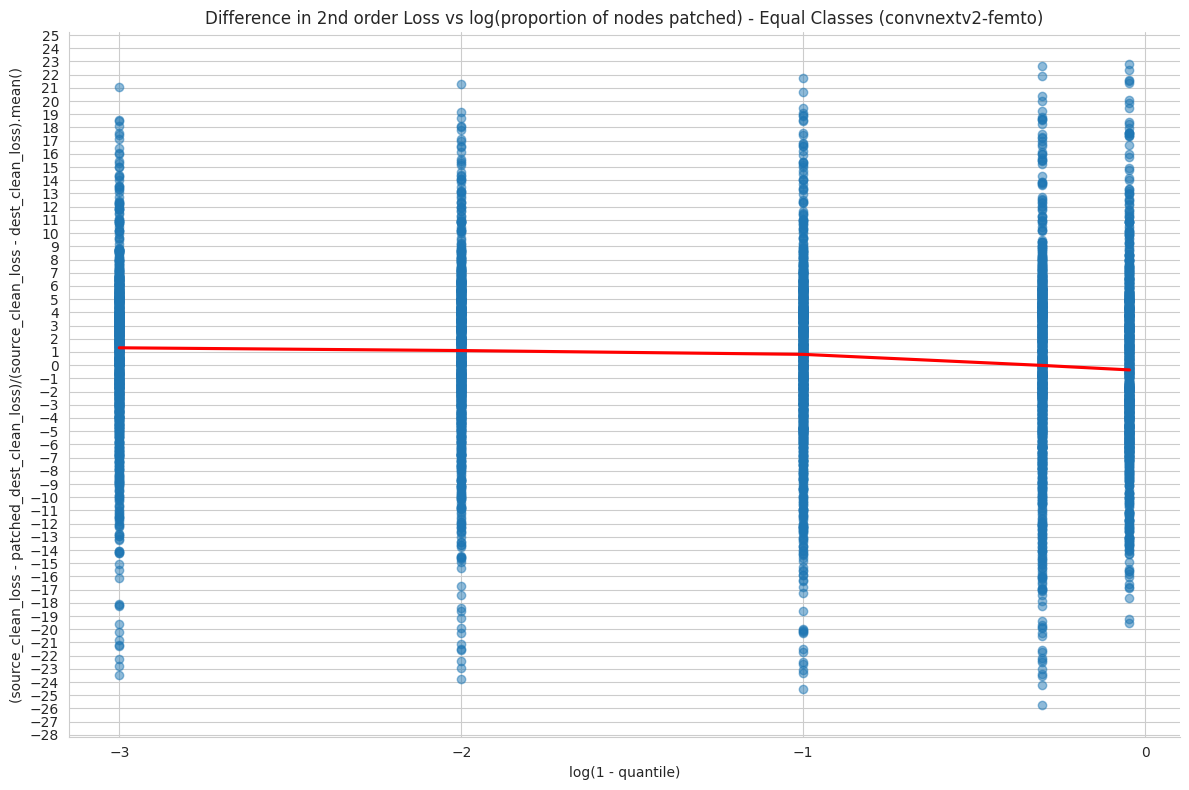

<Figure size 1200x800 with 0 Axes>

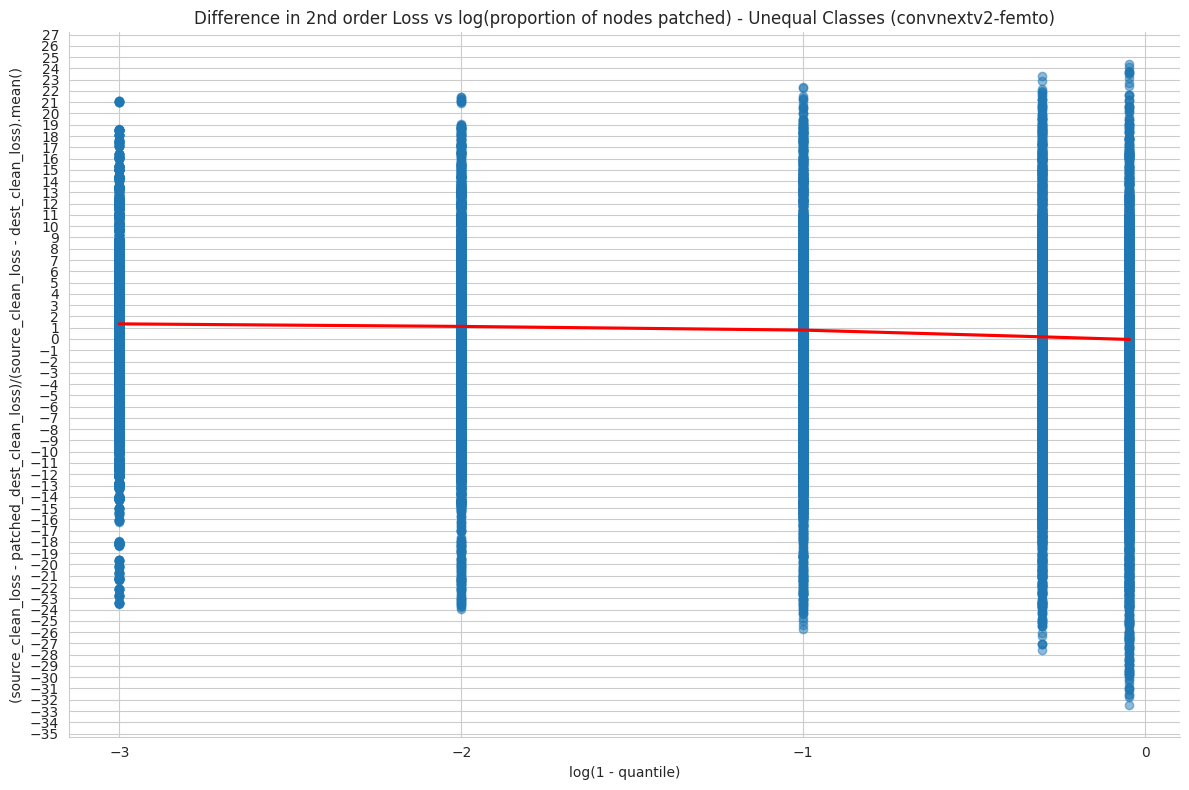

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")

df = pd.read_csv('convnext-femto-image-node-results_all_labels.csv')
node_df = df

# Calculate the difference
df['diff'] = (df['source_clean_loss'] - df['patched_clean_loss']) / (df['source_clean_loss'] - df['unpatched_clean_loss']).mean()

# Calculate log(1-quantile)
df['log_1_minus_quantile'] = np.log10(1 - df['quantile'])

# Function to create the plot
def create_plot(data, title, clean_or_corrupt = 'clean'):
    plt.figure(figsize=(12, 8))
    g = sns.lmplot(
        data=data,
        x='log_1_minus_quantile',
        y='diff',
        height=8,
        aspect=1.5,
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'red'},
        lowess=True
    )

    plt.xlabel('log(1 - quantile)')
    plt.ylabel('(source_clean_loss - patched_dest_clean_loss)/(source_clean_loss - dest_clean_loss).mean()')
    plt.title(f'{title} (convnextv2-femto)')
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))

    plt.tight_layout()
    plt.show()

# Create plot for equal patch_class and eval_class
equal_df = df[df['patch_class'] == df['eval_class']]
create_plot(equal_df, 'Difference in 2nd order Loss vs log(proportion of nodes patched) - Equal Classes')

# Create plot for unequal patch_class and eval_class
unequal_df = df[df['patch_class'] != df['eval_class']]
create_plot(unequal_df, 'Difference in 2nd order Loss vs log(proportion of nodes patched) - Unequal Classes')

<Figure size 1200x800 with 0 Axes>

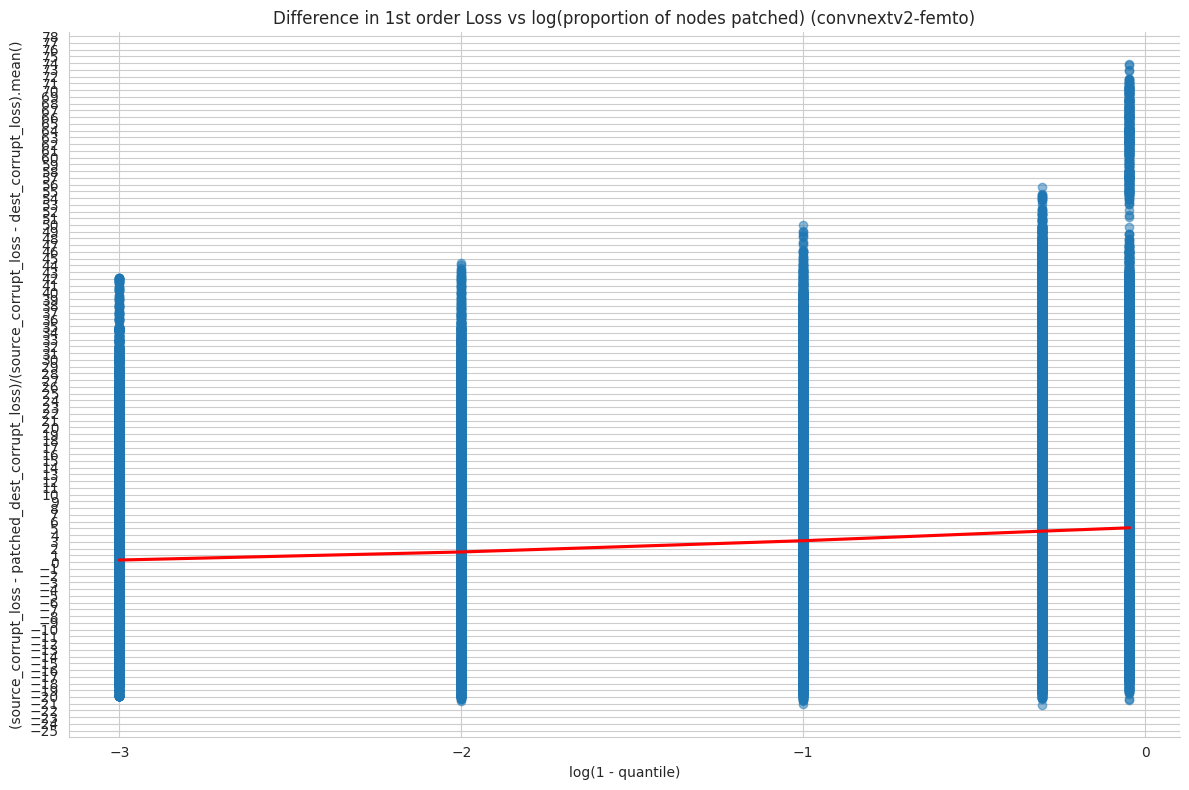

In [9]:
# Calculate the difference
df['diff'] = (df['source_corrupt_loss'] - df['patched_corrupt_loss']) / (df['source_corrupt_loss'] - df['unpatched_corrupt_loss']).mean()

# Calculate log(1-quantile)
df['log_1_minus_quantile'] = np.log10(1 - df['quantile'])

# Create the lmplot
plt.figure(figsize=(12, 8))
# Create the lmplot
g = sns.lmplot(
    data=df,
    x='log_1_minus_quantile',
    y='diff',
    height=8,
    aspect=1.5,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
    lowess=True
)


plt.xlabel('log(1 - quantile)')
plt.ylabel('(source_corrupt_loss - patched_dest_corrupt_loss)/(source_corrupt_loss - dest_corrupt_loss).mean()')
plt.title('Difference in 1st order Loss vs log(proportion of nodes patched) (convnextv2-femto)')
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

plt.tight_layout()
plt.show()

In [10]:
node_df.groupby(['quantile']).mean()

,Unnamed: 0,patch_class,eval_class,unpatched_clean_loss,patched_clean_loss,source_clean_loss,unpatched_corrupt_loss,patched_corrupt_loss,source_corrupt_loss,diff,log_1_minus_quantile
quantile,,,,,,,,,,,
0.100,5119.5,4.5,4.384766,2.035215,2.360237,2.185566,1.959724,2.421226,1.898606,8.551016,-0.045757
0.500,15359.5,4.5,4.384766,2.035215,2.242756,2.185566,1.959724,2.332492,1.898606,7.099162,-0.301030
0.900,25599.5,4.5,4.384766,2.035215,2.138106,2.185566,1.959724,2.173067,1.898606,4.490677,-1.000000
0.990,35839.5,4.5,4.384766,2.035215,2.060977,2.185566,1.959724,2.018584,1.898606,1.963050,-2.000000
0.999,46079.5,4.5,4.384766,2.035215,2.039440,2.185566,1.959724,1.969532,1.898606,1.160473,-3.000000


In [42]:
edge_df.groupby(['quantile']).mean()

,label,n_edges,source_clean_loss,source_corrupt_loss,dest_clean_loss,dest_corrupt_loss,patched_dest_clean_loss,patched_dest_corrupt_loss,patched_rand_dest_clean_loss,patched_rand_dest_corrupt_loss,diff,log_1_minus_quantile
quantile,,,,,,,,,,,,
0.100,4.428571,3311539.0,2.218058,1.989776,1.944182,1.446332,2.077585,1.868930,2.081081,1.864504,0.512906,-0.045757
0.500,4.428571,1839744.0,2.218058,1.989776,1.944182,1.446332,2.101938,1.988879,2.081081,1.864504,0.423988,-0.301030
0.900,4.428571,367949.0,2.218058,1.989776,1.944182,1.446332,2.128486,2.065750,2.047348,1.963122,0.327051,-1.000000
0.990,4.428571,36795.0,2.218058,1.989776,1.944182,1.446332,2.005047,1.729366,1.991047,1.735038,0.777763,-2.000000
0.999,4.428571,3680.0,2.218058,1.989776,1.944182,1.446332,1.949109,1.496807,1.961071,1.505243,0.982010,-3.000000


<Figure size 1200x800 with 0 Axes>

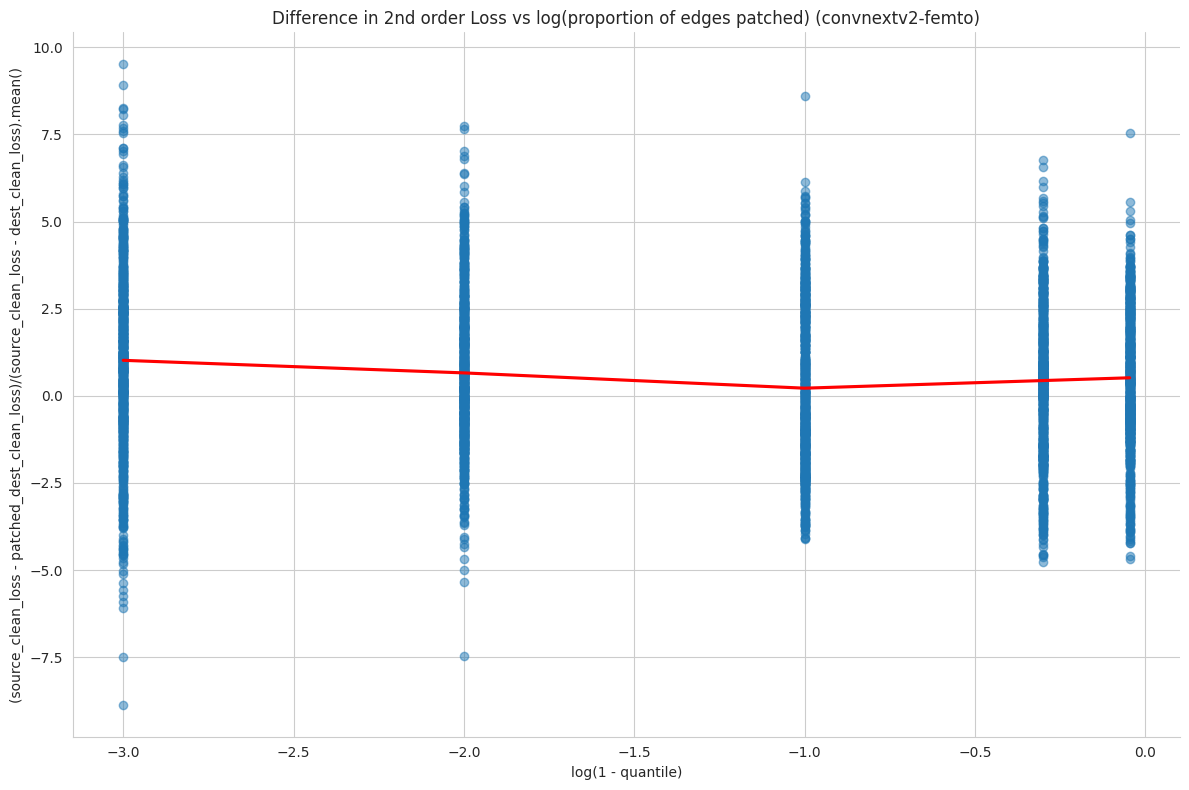

In [18]:

# Read the CSV file
df = pd.read_csv('../convnext-femto_circuit_scores_daat.csv')


# Calculate the difference
df['diff'] = (df['source_clean_loss'] - df['patched_dest_clean_loss']) / (df['source_clean_loss'] - df['dest_clean_loss']).mean()

# Calculate log(1-quantile)
df['log_1_minus_quantile'] = np.log10(1 - df['quantile'])

# Create the lmplot
plt.figure(figsize=(12, 8))
# Create the lmplot
g = sns.lmplot(
    data=df,
    x='log_1_minus_quantile',
    y='diff',
    height=8,
    aspect=1.5,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
    lowess=True
)


plt.xlabel('log(1 - quantile)')
plt.ylabel('(source_clean_loss - patched_dest_clean_loss)/(source_clean_loss - dest_clean_loss).mean()')
plt.title('Difference in 2nd order Loss vs log(proportion of edges patched) (convnextv2-femto)')


plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

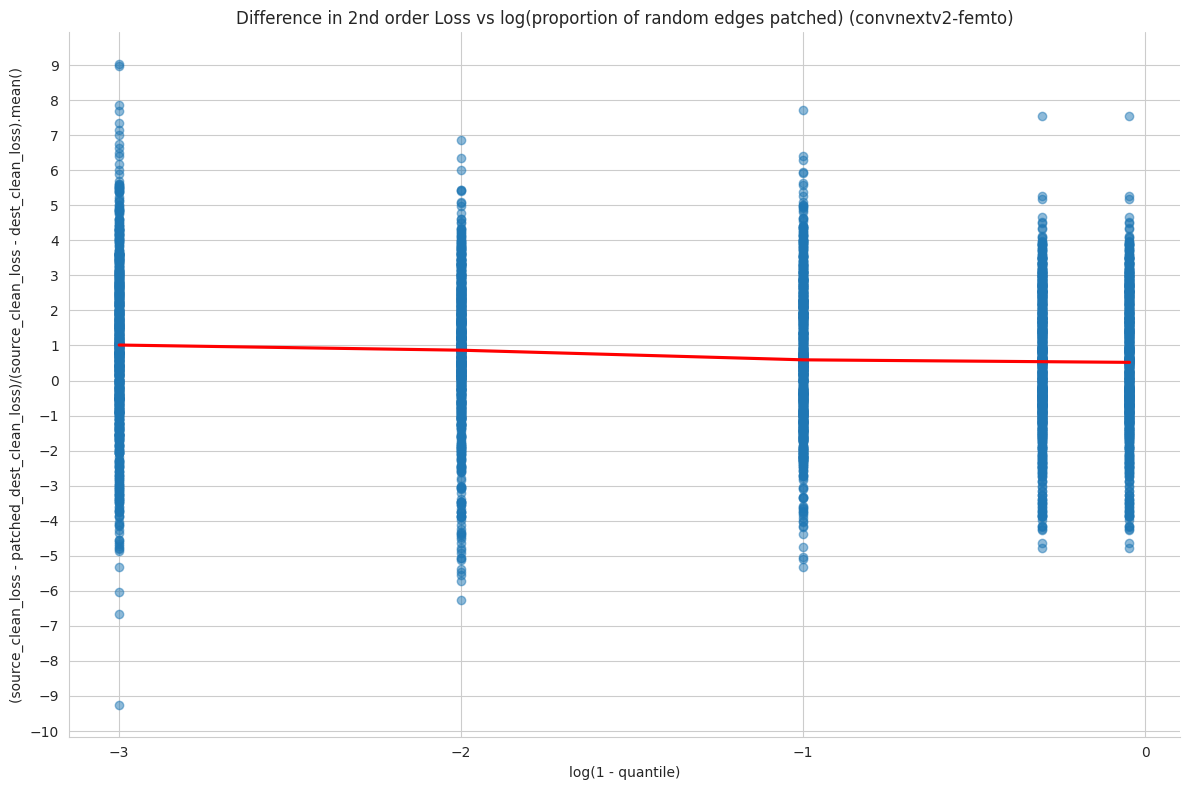

In [7]:

# Calculate the difference
df['diff'] = (df['source_clean_loss'] - df['patched_rand_dest_clean_loss']) / (df['source_clean_loss'] - df['dest_clean_loss']).mean()

# Calculate log(1-quantile)
df['log_1_minus_quantile'] = np.log10(1 - df['quantile'])

# Create the lmplot
plt.figure(figsize=(12, 8))
# Create the lmplot
g = sns.lmplot(
    data=df,
    x='log_1_minus_quantile',
    y='diff',
    height=8,
    aspect=1.5,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
    lowess=True
)


plt.xlabel('log(1 - quantile)')
plt.ylabel('(source_clean_loss - patched_dest_clean_loss)/(source_clean_loss - dest_clean_loss).mean()')
plt.title('Difference in 2nd order Loss vs log(proportion of random edges patched) (convnextv2-femto)')
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

plt.tight_layout()
plt.show()

In [8]:
# Calculate the difference
df['diff'] = (df['source_corrupt_loss'] - df['patched_dest_corrupt_loss']) / (df['source_corrupt_loss'] - df['dest_corrupt_loss']).mean()

# Calculate log(1-quantile)
df['log_1_minus_quantile'] = np.log10(1 - df['quantile'])

# Create the lmplot
plt.figure(figsize=(12, 8))
# Create the lmplot
g = sns.lmplot(
    data=df,
    x='log_1_minus_quantile',
    y='diff',
    height=8,
    aspect=1.5,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
    lowess=True
)


plt.xlabel('log(1 - quantile)')
plt.ylabel('(source_corrupt_loss - patched_dest_corrupt_loss)/(source_corrupt_loss - dest_corrupt_loss).mean()')
plt.title('Difference in 1st order Loss vs log(proportion of edges patched) (convnextv2-femto)')
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

plt.tight_layout()
plt.show()

KeyError: 'patched_dest_corrupt_loss'

<Figure size 1200x800 with 0 Axes>

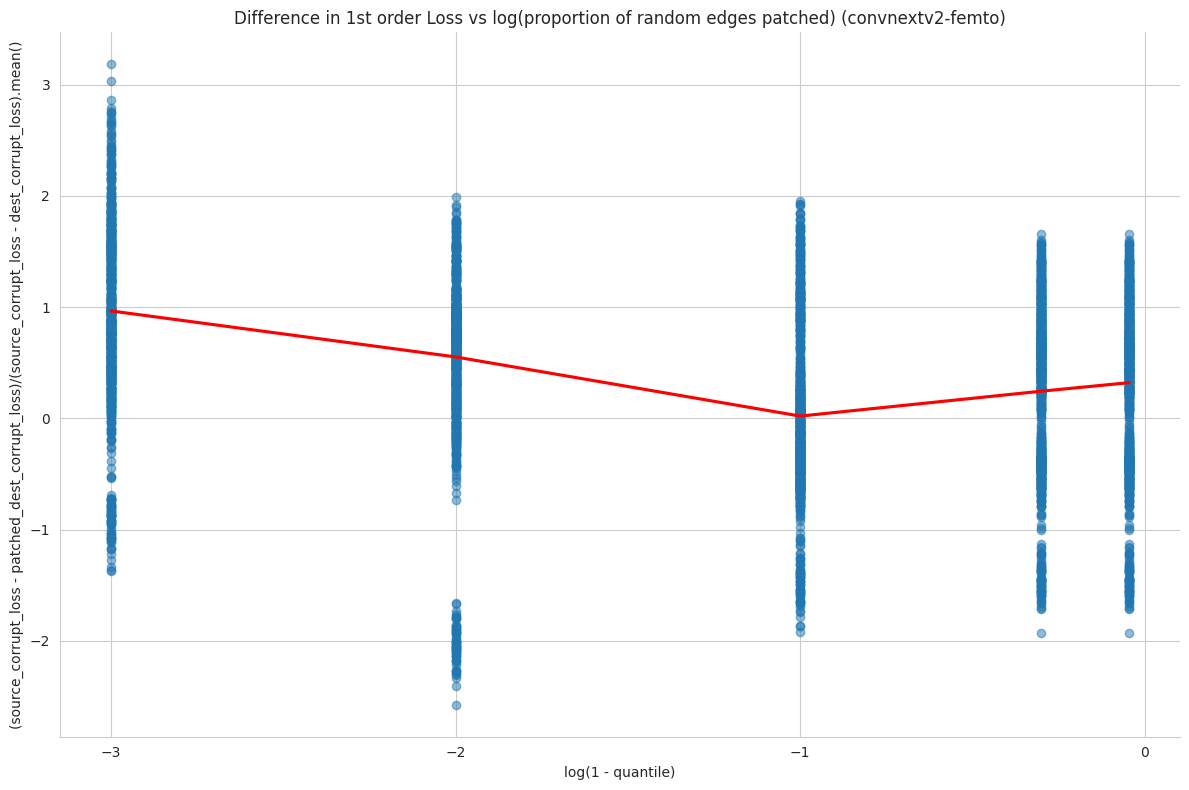

In [9]:
# Calculate the difference
df['diff'] = (df['source_corrupt_loss'] - df['patched_rand_dest_corrupt_loss']) / (df['source_corrupt_loss'] - df['dest_corrupt_loss']).mean()

# Calculate log(1-quantile)
df['log_1_minus_quantile'] = np.log10(1 - df['quantile'])

# Create the lmplot
plt.figure(figsize=(12, 8))
# Create the lmplot
g = sns.lmplot(
    data=df,
    x='log_1_minus_quantile',
    y='diff',
    height=8,
    aspect=1.5,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
    lowess=True
)


plt.xlabel('log(1 - quantile)')
plt.ylabel('(source_corrupt_loss - patched_dest_corrupt_loss)/(source_corrupt_loss - dest_corrupt_loss).mean()')
plt.title('Difference in 1st order Loss vs log(proportion of random edges patched) (convnextv2-femto)')
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

plt.tight_layout()
plt.show()

In [ ]:
def create_prompt_dataset_from_quantile_normalized(
    qn_dataset: QuantileNormalizedDataset,
    original_dataset: Dataset,
    img_col: str = "pixel_values",
    label_col: str = "label"
) -> PromptDataset:
    clean_prompts = []
    corrupt_prompts = []
    answers = []
    wrong_answers = []

    for i in range(len(qn_dataset)):
        original_sample = original_dataset[i]
        qn_sample = qn_dataset[i]

        clean_prompts.append(original_sample[img_col])
        corrupt_prompts.append(qn_sample[img_col])
        
        # Assuming the label is a single integer
        answers.append(torch.tensor([original_sample[label_col]]))
        wrong_answers.append(torch.tensor([qn_sample[label_col]]))

    return PromptDataset(
        clean_prompts=clean_prompts,
        corrupt_prompts=corrupt_prompts,
        answers=answers,
        wrong_answers=wrong_answers
    )

In [ ]:
def prepare_dataset(dataset_str: str):
    seed = 42

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Allow specifying load_dataset("svhn", "cropped_digits") as "svhn:cropped_digits"
    # We don't use the slash because it's a valid character in a dataset name
    path, _, name = dataset_str.partition(":")
    ds = load_dataset(path, name or None)
    assert isinstance(ds, DatasetDict)

    # Infer columns and class labels
    img_col, label_col = infer_columns(ds["train"].features)
    labels = ds["train"].features[label_col].names
    print(f"Classes in '{dataset_str}': {labels}")

    # Convert to RGB so we don't have to think about it
    ds = ds.map(lambda x: {img_col: x[img_col].convert("RGB")})

    # Infer the image size from the first image
    example = ds["train"][0][img_col]
    c, (h, w) = len(example.mode), example.size
    print(f"Image size: {h} x {w}")

    train_trf = T.Compose(
        [
            T.RandAugment(),
            T.RandomHorizontalFlip(),
            T.RandomCrop(h, padding=h // 8),
            T.ToTensor(),
        ]
    )

    train = ds["train"].with_format("torch")
    X = assert_type(Tensor, train[img_col]).div(255)
    # X = rearrange(X, "n h w c -> n c h w")
    Y = assert_type(Tensor, train[label_col])

    print("Computing statistics...")
    fitter = QuadraticFitter.fit(X.flatten(1).cuda(), Y.cuda())
    normalizer = QuantileNormalizer(X, Y)
    print("Done.")

    def preprocess(batch):
        return {
            "pixel_values": [TF.to_tensor(x) for x in batch[img_col]],
            "label": torch.tensor(batch[label_col]),
        }

    if val := ds.get("validation"):
        test = ds["test"].with_transform(preprocess) if "test" in ds else None
        val = val.with_transform(preprocess)
    else:
        nontrain = ds["test"].train_test_split(train_size=1024, seed=seed)
        val = nontrain["train"].with_transform(preprocess)
        test = nontrain["test"].with_transform(preprocess)

    class_probs = torch.bincount(Y).float()
    gaussian = GaussianMixture(
        fitter.mean_x.cpu(), fitter.sigma_xx.cpu(), class_probs, len(val), (c, h, w)
    )

    train = (
        ds["train"].with_transform(
            lambda batch: {
                "pixel_values": [train_trf(x) for x in batch[img_col]],
                "label": batch[label_col],
            },
        )
    )

    cache = Path.cwd() / "editor-cache" / f"{dataset_str}.pkl"
    if cache.exists():
        with open(cache, "rb") as f:
            editor = pickle.load(f)
    else:
        print("Computing optimal transport maps...")

        editor = fitter.editor("cpu")
        cache.parent.mkdir(exist_ok=True)

        with open(cache, "wb") as f:
            pickle.dump(editor, f)

    with val.formatted_as("torch"):
        X = assert_type(Tensor, val[img_col]).div(255)
        # X = rearrange(X, "n h w c -> n c h w")
        Y = assert_type(Tensor, val[label_col])

    val_sets = {
        "independent": IndependentCoordinateSampler(class_probs, normalizer, len(val)),
        "got": ConceptEditedDataset(class_probs, editor, X, Y),
        "gaussian": gaussian,
        "real": val,
        "cqn": QuantileNormalizedDataset(class_probs, normalizer, X, Y),
    }

    return val_sets

In [ ]:
val_sets = prepare_dataset(dataset_str)

In [ ]:
model.edge_dict

In [ ]:
val_sets.keys()

In [ ]:
pdset = create_prompt_dataset_from_quantile_normalized(val_sets["cqn"], val_sets["real"])
ploader = PromptDataLoader(pdset, None, 0, batch_size=16, shuffle=True)

In [ ]:
%pdb on
ablations = batch_src_ablations(model, ploader, AblationType.RESAMPLE, 'corrupt')

In [ ]:
patch_edges = model.edge_dict[:100]

In [ ]:
ablations_batch = next(iter(ablations.values()))


In [ ]:
with patch_mode(model, ablations_batch, patch_edges):
    for batch in ploader:
        patched_out = model(batch.clean.to(model.wrapped_model.device))